# PREPROCESSING COLOSSEUM DATA TO LINKED DATA
In this notebook, we preprocess BIM, PCD and IMG data of the Colosseum to RDF Graphs.

>This codebase operates on the scan2bim2.yml environment (python 3.8) and ifcopenshell

In [1]:
#IMPORT PACKAGES
from rdflib import Graph, URIRef
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
import ifcopenshell.util.selector
import random as rd
import pandas as pd
from tabulate import tabulate
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
import pathlib

#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.utils import imageutils as iu
import geomapi.tools as tl
from geomapi.tools import progresstools as pt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2

## SETUP

general

In [4]:
## INPUTS
projectPath= os.path.join("D:\\Data\\2023-01 Colosseum")
sessionPath = os.path.join(projectPath,"Research")

gallery 1

In [5]:
#PCD
lasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test4 - Cloud - classes.las")

#IMG
xmlPath=os.path.join(projectPath,'Research','IMG','cameras.xml')
# imgGraphPath=os.path.join(sessionPath,"IMG","imgGraph.ttl")
pixelWidth=0.0060975609756097563
f= 2668.8837741268403

#offset
transform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06 ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,-2.5068223291342328e+01],
                [0.0 ,0.0, 0.0, 1.000000000000]])

#image training data
listgrouping=['01 Materiali', '02 TC', '03 D']
listnames=['material','buildingTechnique','damage']
pixelRange=224 #pixel size of exported training data
trainingFolder=os.path.join(sessionPath,"IMG_training_224")
imgTrainingGraphPath=os.path.join(trainingFolder,"imgTrainingGraph.ttl")
materialTrainingFolder=os.path.join(trainingFolder,"Materials")
BuildingTechniqueTrainingFolder=os.path.join(trainingFolder,"BuildingTechniques")
DamageTrainingFolder=os.path.join(trainingFolder,"Damages")


facade

In [6]:
#PCD
lasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test5 - Cloud - classes.las")
transform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06 ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,-2.5068223291342328e+01],
                [0.0 ,0.0, 0.0, 1.000000000000]])
#Images
xmlPath=os.path.join(projectPath,'IMG3','Cantiere_pilota_cameras.xml')
sensorid=11
pixelWidth=0.0043948613649283609
focalLength35mm= 8196.120157529791

rotation=np.array([[4.1458532257958308e-01, 9.0392097872801924e-01 ,-1.0509935545455225e-01,0],
                        [ 9.0916313459383069e-01, -4.1641033853698489e-01, 4.9824346492534097e-03,0],
                        [-3.9260730980247453e-02, -9.7618103725144317e-02, -9.9444924497331855e-01,0],
                        [0,0,0,1]])

#image training data
listgrouping=['01 Materiali', '02 TC', '03 D']
listnames=['material','buildingTechnique','damage']
pixelRange=224 #pixel size of exported training data
trainingFolder=os.path.join(sessionPath,"Facade_classification")
imgTrainingGraphPath=os.path.join(trainingFolder,"imgTrainingGraph.ttl")
materialTrainingFolder=os.path.join(trainingFolder,"Materials")
BuildingTechniqueTrainingFolder=os.path.join(trainingFolder,"BuildingTechniques")
DamageTrainingFolder=os.path.join(trainingFolder,"Damages")
pixelRange=224
skip=10 #nth file tu use

Nave

In [7]:
sessionPath = os.path.join(projectPath,"Nave")
lasPath=os.path.join(sessionPath,"PCD","Galleria_intermedia.las")
xmlPath=os.path.join(sessionPath,'IMG','Cantiere_pilota_cameras.xml')


## PREPROCESS POINT CLOUD

Create point cloud node with proper offset.

In [22]:
las  = laspy.read(lasPath)
pcd=gmu.las_to_pcd(las,transform=transform)
pcdNode=PointCloudNode(name=ut.get_filename(lasPath),
                        lasPath=lasPath,
                        resource=pcd
                        )

In [8]:
# pcdNode=tl.graph_path_to_nodes(graphPath=pcdGraphPath,getResource=True)[0]
# print(str(len(ut.item_to_list(pcdNode))) + ' pcdNode')

# clusteredpcdNodes=tl.graph_path_to_nodes(graphPath=clusteredPcdGraphPath,getResource=True)
# clusteredpcdNodes=[n for n in clusteredpcdNodes if n.resource]
# print(str(len(clusteredpcdNodes)) + ' clusteredpcdNodes')

# imgNodes=tl.graph_path_to_nodes(graphPath=imgGraphPath,getResource=True,getMetaData=False)
# imgNodes=[n for n in imgNodes if n.resource is not None]
# print(str(len(imgNodes)) + ' imgNodes')

## PREPROCESS THE IMAGES WITH THE POINT CLOUD

In [23]:
imgNodes=tl.img_xml_to_nodes2(xmlPath,skip=skip,filterByFolder=True)
for n in imgNodes:
    n.cartesianTransform=transform @ n.cartesianTransform  
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

77 Nodes created!
77


In [21]:
{key:value for key, value in imgNodes[40].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Colosseum\\Nave\\IMG\\Cantiere_pilota_cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 3936,
 'imageHeight': 2624,
 'focalLength35mm': 2669.207400212602,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///DSC01761'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/2023-01 Colosseum/Nave/IMG/DSC01761.JPG',
 '_name': 'DSC01761',
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': array([[-0.11528453, -0.74556865, -0.65638165, 17.1325389 ],
        [-0.05318321,  0.66447247, -0.74541792, 12.0196741 ],
        [ 0.99190777, -0.05102667, -0.11625513,  0.79850337],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [11]:
#get list of files
files=ut.get_list_of_files(ut.get_folder(xmlPath))
files=[f for f in files if f.endswith('.JPG')]

#! select one node every 50 files
imgNodes=[]
for f in files[0::skip]:    
    imgNodes.append(ImageNode(name=ut.get_filename(f),
              path=f,
              xmlPath=xmlPath,
                focalLength35mm=focalLength35mm))
    
# open   
# create set of sensors


# apply transform to put imagery in local coordinates
for n in imgNodes:
    n.cartesianTransform=rotation @ n.cartesianTransform    
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

89 Nodes created!


Visualize images, point cloud and clustered point clouds

In [24]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

**Fig.**: Images of the (a) point cloud clustered per D,TC,M (212 clusters) and (b) image DSC03537, DSC03509, DSC03500 + locations.

<img src="../docs/pics/colosseum/cluster3.PNG" width = "25%">
<img src="../docs/pics/colosseum/DSC03537.JPG" width = "15%">
<img src="../docs/pics/colosseum/DSC03509.JPG" width = "15%">
<img src="../docs/pics/colosseum/DSC03500.JPG" width = "15%">

# Generate classification images for training

## Split original images into regions and generate rays.

In [7]:
points=[]
imgTrainingNodes=[]
for n in imgNodes:
    imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)
    imagePoints=np.vstack([np.array([sum(x[:2])/2,sum(x[2:4])/2]) for x in roiList])
    rays=n.create_rays(imagePoints)
    #create a new list of imageNodes
    nodeList=[]
    for img,roi,ray in zip(imgList,roiList,rays):
        nodeList.append(ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                ray=ray))                    
    #add to nodelist   
    imgTrainingNodes.extend(nodeList) 
print(len(imgTrainingNodes))

3740


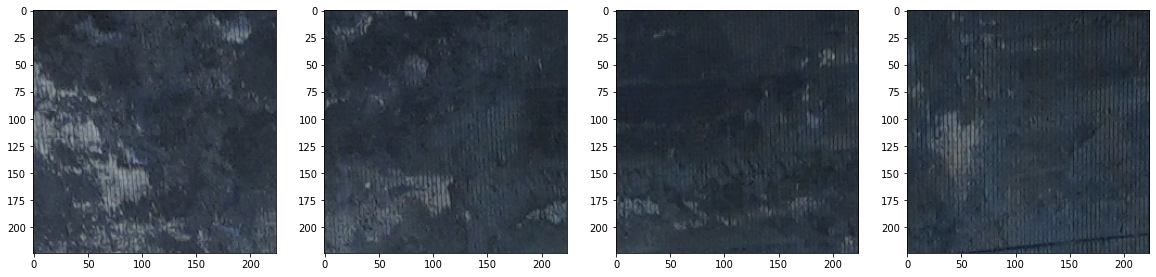

In [8]:
plt.figure(figsize=(20,10))
columns = 5
for i, n in enumerate(imgTrainingNodes[3:7]):
    plt.subplot(1, 4, i + 1)
    plt.imshow(n.resource)

In [9]:

# for n in imgTrainingNodes:
#     originalImage=next(i for i in imgNodes if n.isDerivedFrom==i.subject)
    
#     K=originalImage.get_intrinsic_camera_parameters().intrinsic_matrix
#     M=originalImage.cartesianTransform
#     T=gmu.get_translation(originalImage.cartesianTransform)  
    
#     # get uv_points -> this is correct
#     u=(n.roi[2]+n.roi[3])/2-originalImage.imageWidth/2
#     v=-(n.roi[0]+n.roi[1])/2+originalImage.imageHeight/2    
#     # print(u,v) 
#     uv_coordinates=np.array([v,u,1]) 
#     #transform to image coordinates
#     # camera_coordinates=np.linalg.inv(K) @ uv_coordinates.T
    
#     #transform to world coordinates
#     camera_coordinates=np.array([uv_coordinates[0],uv_coordinates[1],originalImage.focalLength35mm,1])  
#     world_coordinates=originalImage.cartesianTransform @ camera_coordinates.T
#     world_coordinates=gmu.normalize_vectors(world_coordinates.T)
#     print(world_coordinates)

#     n.projectionRay=np.hstack((T,world_coordinates[0,0:3])) 

# # #group all the rays of the imgTrainingNodes
# array=np.vstack([n.projectionRay for n in imgTrainingNodes])

# rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32)  
# print(rays.numpy()[0:4,:])

## Group and visualize rays

In [10]:
array=np.vstack([n.ray for n in imgTrainingNodes])
rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32)  
line_set=gmu.rays_to_lineset(rays)
line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
o3d.visualization.draw_geometries([line_set]+[pcdNode.resource])

In [11]:
#test rays from camera 1 -> this times out
# intrinsic_matrix = o3d.cpu.pybind.core.Tensor( imgNodes[0].cartesianTransform[0:3,0:3],dtype=o3d.core.Dtype.Float32) 
# extrinsic_matrix = o3d.cpu.pybind.core.Tensor(np.linalg.inv(imgNodes[0].cartesianTransform),dtype=o3d.core.Dtype.Float32) 
# width_px=  int(imgNodes[0].imageWidth)
# height_px =  int(imgNodes[0].imageHeight)

# rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
#     intrinsic_matrix=intrinsic_matrix,
#     extrinsic_matrix=extrinsic_matrix,
#     width_px=width_px,
#     height_px=height_px
# )
# print(rays)

In [12]:
# # test rays from camera 2
# rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
#     fov_deg=90,
#     center=[-26.21284904,         3.97848395,  -0.22206429], #where you look at
#     eye=[-16.1386638 ,  15.0919998 ,  -0.19845457], #camera center
#     up=[0, 0, 1],
#     width_px=640,
#     height_px=480,
# )
# rays=rays.numpy()
# rays=rays[::-1]
# rays=np.flip(rays, 1)
# rays=np.reshape(rays,(-1, 6))
# rays = o3d.core.Tensor(rays,dtype=o3d.core.Dtype.Float32)  

# print(rays)

**Fig.**: Overview of (a) the rays per subdivided imgTrainingNode and (b) convex hull geometries in the raycasting scene.

<img src="../docs/pics/colosseum/Raycasting_1.PNG" width = "25%">
<img src="../docs/pics/colosseum/boxes1.PNG" width = "19.5%">


## Cast the rays and evaluate the ids and distances.

In [13]:
geometries=[n.resource for n in clusteredpcdNodes if n.resource]
distances,ids=gmu.compute_raycasting_collisions(geometries,rays)
print(distances,ids)

[      inf 10.157836 10.09679  ...       inf       inf       inf] [4294967295         48         69 ... 4294967295 4294967295 4294967295]


In [14]:
# print(np.unique(ids))

In [15]:
# import matplotlib.pyplot as plt
# test=np.reshape(distances,(21,14))
# print(test.shape)
# plt.imshow(test)

## Assign pcdNode information to trainingimageNodes

In [16]:
for n,d,id in zip(imgTrainingNodes,distances,ids):
    invalid_id=o3d.t.geometry.RaycastingScene.INVALID_ID
    n.material=clusteredpcdNodes[id].material if id !=invalid_id else -1
    n.damage=clusteredpcdNodes[id].damage if id !=invalid_id else -1
    n.buildingTechnique=clusteredpcdNodes[id].buildingTechnique if id !=invalid_id else -1
    n.distanceToGeometry=d if id !=invalid_id else -1

visualize training labels

In [19]:
colors=[(255,0,0),(0,255,0),(0,0,255)]
import copy

images=[]
for n in imgNodes:
    image=copy.deepcopy(n.resource)
    # select nodes
    nodeList=[tn for tn in imgTrainingNodes if tn.isDerivedFrom ==n.subject]
    #create mask from roi
    for i,c in enumerate(np.unique([n.material for n in clusteredpcdNodes])):        
        roiList= [t.roi for t in nodeList if t.material==c]
        if len(roiList) >0:
            for roi in roiList:
                roi=image[roi[0]:roi[1],roi[2]:roi[3]] 
                roi[:,:,:]=colors[i]
    images.append(image)   

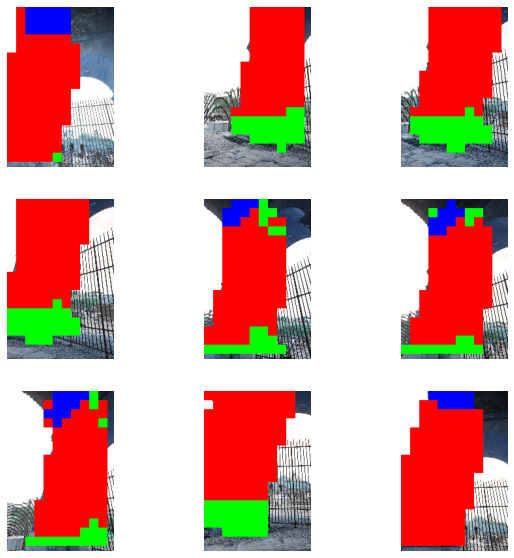

In [20]:
import math
plt.figure(figsize=(10, 10))
for i,img in enumerate(images[0:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.axis("off")

# CREATE TRAINING SAMPLES FROM POINT CLOUD

Gather statistics from point cloud

In [6]:
las  = laspy.read(lasPath)
pcd=gmu.las_to_pcd(las,transform=transform)
print(pcd)
print(np.unique(las['01 Materiali']))
print(np.unique(las['02 TC']))
print(np.unique(las['03 D']))

[0. 1. 4.]
[0. 1. 2. 3. 6. 7. 8.]
[0. 1. 2. 3.]


In [13]:
materialSet=np.unique(las['01 Materiali'])
BuildingTechniqueSet=np.unique(las['02 TC'])
DamageSet=np.unique(las['03 D'])
print(materialSet)
print(BuildingTechniqueSet)
print(DamageSet)

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4. 5. 6. 8.]
[0. 1. 2.]


Gather images

In [7]:
# #IMGNODES
# imgNodes=tl.img_xml_to_nodes(xmlPath)
# imgNodes=[n for n in imgNodes if n.cartesianTransform is not None and n.path is not None and os.path.exists(n.path)]
# for n in imgNodes:
#     rotation=np.array([[4.1458532257958308e-01, 9.0392097872801924e-01 ,-1.0509935545455225e-01,0],
#                         [ 9.0916313459383069e-01, -4.1641033853698489e-01, 4.9824346492534097e-03,0],
#                         [-3.9260730980247453e-02, -9.7618103725144317e-02, -9.9444924497331855e-01,0],
#                         [0,0,0,1]])
#     n.cartesianTransform=rotation @ n.cartesianTransform
#     n.offsetTransform=transform
#     n.focalLength35mm=f
#     n.pixelWidth=pixelWidth
# meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]

# print(str(len(imgNodes))+ " Nodes created!")

68 Nodes created!


Generate training samples

In [22]:
point_cloud=copy.deepcopy(pcd)
imgTrainingNodes=[]

for listgroup,listname in zip(listgrouping[2:3],listnames[2:3]): #'01 Materiali', '02 TC', '03 D'
    
    #create colors per class
    classes=np.unique(las[listgroup])
    print(classes)
    colors=np.array([ut.random_color(255) for v in range(len(classes))])
    print(colors)
    grayColors=iu.rgb2gray(colors)/255
    classes=np.append(classes,-1)

    #assign colors to point cloud
    colorArray=gmu.array_to_colors(las[ listgroup],colors)
    point_cloud.colors=o3d.utility.Vector3dVector(colorArray)
    for n in imgNodes: #! don't do this for full list unless you are certain
        #raytrace scene
        colorImage,depthImage=pt.project_pcd_to_rgbd_images(point_cloud,n,depth_max=20,fill_black=5)
        
        imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)
        classImgList,_=iu.subdivide_image(iu.rgb2gray(colorImage[0]),width=pixelRange,height=pixelRange,includeLast=False)
        
        for img,roi,cimg in zip(imgList,roiList,classImgList):
            # remove 0 pixels

            values, counts = np.unique(cimg, return_counts=True) 
            i_0=values.tolist().index(0.0)
            values=np.delete(values, i_0)
            counts=np.delete(counts, i_0)
            
            if counts.shape[0]>0:
                i = np.argmax(counts)
                # print(values)
                index = (np.abs(grayColors - values[i])).argmin() if any(np.isclose(values[i],grayColors, atol=0.001)) else -1                 
            else:
                index=-1  
            # assign information to imgTrainingNodes   
            node=ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                cimg=cimg)
            setattr(node,listname, classes[index])
            imgTrainingNodes.append(node) #! this creates double of samples
print(len(imgTrainingNodes))

[0. 1. 2.]
[[ 56  13  80]
 [183 254  65]
 [212  87 143]]
76896


(include rays) training samples

In [42]:
point_cloud=copy.deepcopy(pcd)
imgTrainingNodes=[]

for listgroup,listname in zip(listgrouping[1:2],listnames[1:2]): #'01 Materiali', '02 TC', '03 D'
    
    #create colors per class
    classes=np.unique(las[listgroup])
    print(classes)
    # colors=np.array([ut.random_color() for v in range(len(classes))])
    colors=np.array([[0,255,0],[255,0,0],[0,0,255]])
    grayColors=iu.rgb2gray(colors)/255
    classes=np.append(classes,-1)

    #assign colors to point cloud
    colorArray=gmu.array_to_colors(las[ listgroup],colors)
    point_cloud.colors=o3d.utility.Vector3dVector(colorArray)
    for n in imgNodes: #! don't do this for full list unless you are certain
        #raytrace scene
        colorImage,depthImage=pt.project_pcd_to_rgbd_images(point_cloud,n,depth_max=20)
        imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)
        classImgList,_=iu.subdivide_image(iu.rgb2gray(colorImage[0]),width=pixelRange,height=pixelRange,includeLast=False)
        
        for img,roi,cimg in zip(imgList,roiList,classImgList):
            # remove 0 pixels

            values, counts = np.unique(cimg, return_counts=True) 
            i_0=values.tolist().index(0.0)
            values=np.delete(values, i_0)
            counts=np.delete(counts, i_0)
            
            if counts.shape[0]>0:
                i = np.argmax(counts)
                index = grayColors.tolist().index(values[i]) if any(values[i]==c for c in grayColors) else -1 
            else:
                index=-1  
            # assign information to imgTrainingNodes   
            node=ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi)
            setattr(node,listname, classes[index])
            imgTrainingNodes.append(node) 
print(len(imgTrainingNodes))

[0. 1. 2. 3. 4. 5. 6. 8.]


IndexError: tuple index out of range

In [23]:
{key:value for key, value in imgTrainingNodes[1000].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 224,
 'imageHeight': 224,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///15a568ef-a30e-11ed-9a06-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': '15a568ef-a30e-11ed-9a06-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[126, 113,  91],
         [127, 114,  92],
         [126, 113,  91],
         ...,
         [124, 113,  91],
         [126, 118,  95],
         [128, 120,  97]],
 
        [[125, 112,  90],
         [126, 113,  91],
         [126, 113,  91],
         ...,
         [124, 116,  93],
         [124, 116,  93],
         [123, 115,  92]],
 
        [[123, 110,  88],
         [125, 112,  90],
         [125, 112,  90],
         ...,
         [126, 118,  95],
         [124, 116,  93],
         [122, 114,  91]],
 
        ...,
 
        [[ 18,  21,  19],
         [ 20,  23,  21],
         [ 22,  25,  23],
         ...,
         [ 28,  28,

## EXPORT TRAINING SAMPLES

Save resources in seperate folders for material training.

In [17]:
import shutil

shutil.rmtree(materialTrainingFolder) if os.path.exists(materialTrainingFolder) else None 
os.mkdir(materialTrainingFolder) if not os.path.exists(materialTrainingFolder) else None                   

for t in materialSet:
    #gather resources    
    nodes=[n for n in imgTrainingNodes if n.material==t]
    print(len(nodes))
    #save to proper folders
    if len(nodes)>0:
        directory=os.path.join(materialTrainingFolder,str(t))
        os.mkdir(directory) if not os.path.exists(directory) else None                   
        for n in nodes:
            path=os.path.join(directory,n.name+'.png')
            cv2.imwrite(path, n.resource)

12560
21725
1
0
2


Save resources in seperate folders for Building Technique training.

In [25]:
BuildingTechniqueTrainingFolder

'D:\\Data\\2023-01 Colosseum\\Research\\Facade_classification\\BuildingTechniques'

In [21]:
shutil.rmtree(BuildingTechniqueTrainingFolder) if os.path.exists(BuildingTechniqueTrainingFolder) else None 
os.mkdir(BuildingTechniqueTrainingFolder) if not os.path.exists(BuildingTechniqueTrainingFolder) else None                   
for t in BuildingTechniqueSet:
    #gather resources    
    nodes=[n for n in imgTrainingNodes if n.buildingTechnique==t]
    print(len(nodes))
    #save to proper folders
    if len(nodes)>0:
        directory=os.path.join(BuildingTechniqueTrainingFolder,str(t))
        os.mkdir(directory) if not os.path.exists(directory) else None                   
        for n in nodes:
            path=os.path.join(directory,n.name+'.png')
            cv2.imwrite(path, n.resource)

12313
8859
12868
245
1
0
0
2


Save resources in seperate folders for Damage training.

In [24]:
shutil.rmtree(DamageTrainingFolder) if os.path.exists(DamageTrainingFolder) else None 
os.mkdir(DamageTrainingFolder) if not os.path.exists(DamageTrainingFolder) else None                   
for t in DamageSet:
    #gather resources    
    nodes=[n for n in imgTrainingNodes if n.damage==t]
    print(len(nodes))
    #save to proper folders
    if len(nodes)>0:
        directory=os.path.join(DamageTrainingFolder,str(t))
        os.mkdir(directory) if not os.path.exists(directory) else None                   
        for n in nodes:
            path=os.path.join(directory,n.name+'.png')
            cv2.imwrite(path, n.resource)

837
8121
25330


imgTrainingNodeList to graph

In [20]:
bimSeperatorGraph=tl.nodes_to_graph(imgTrainingNodes,imgTrainingGraphPath,save=True)
print (str(len(imgTrainingNodes))+' Nodes succesfully serialized in: '+imgTrainingGraphPath)

12716 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\IMG_training_224\imgTrainingGraph.ttl
